<a href="https://colab.research.google.com/github/simsekergun/Dint_flattening/blob/main/Dint_Flattening_with_an_Aux_Ring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tidy3d

In [2]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.interpolate import Akima1DInterpolator

# tidy3D import
import tidy3d as td
from tidy3d import web
from tidy3d.plugins.mode import ModeSolver

In [3]:
class RefractiveIndexLibrary:
    """
    A class to manage and retrieve refractive indices of various materials.
    """

    def __init__(self):
        self.material_library = {
            'Si3N4': self.get_n_Si3N4,
            'ZnSe': self.get_ZnSe_nk_LWIR,
            'Si': self.get_n_si,
            'SiO2': self.get_n_sio2
        }

    def get_n_Si3N4(self, LAMBDA):
        """
        Calculate refractive index of Si3N4 using Sellmeier equation.

        Parameters:
        LAMBDA : float or array_like (Wavelength in micrometers)

        Returns:
        float or ndarray: Refractive index of Si3N4
        """
        return np.sqrt(1 + 3.0249 / (1 - (0.1353406 / LAMBDA)**2) +
                       40314 / (1 - (1239.842 / LAMBDA)**2))

    def get_ZnSe_nk_LWIR(self, lambda_um):
        """
        Calculate refractive index for ZnSe in LWIR range.

        Parameters:
        lambda_um : float or array_like (Wavelength in micrometers)

        Returns:
        float or ndarray: Refractive index of ZnSe
        """
        x = np.zeros(6)
        x[0] = 2.364510
        x[1] = 0.259237
        x[2] = 2.465825
        x[3] = 0.295839
        x[4] = 0.843897
        x[5] = 1000.007792

        # Convert to numpy array for vector operations
        lambda_um = np.asarray(lambda_um)

        n = np.sqrt(1 + x[0] * lambda_um**2 / (lambda_um**2 - x[1]) +
                       x[2] * lambda_um**2 / (lambda_um**2 - x[3]) +
                       x[4] * lambda_um**2 / (lambda_um**2 - x[5]))

        return n

    def get_n_si(self, x):
        """
        Calculate refractive index of Silicon.

        Parameters:
        x : float or array_like (Wavelength in micrometers)

        Returns:
        float or ndarray: Refractive index of Silicon
        """
        n = (11.67316 + 1/(x**2) + 0.004482633/(x**2 - 1.108205**2))**0.5
        return n

    def get_n_sio2(self, LAMBDA):
        """
        Calculate refractive index of SiO2 (fused silica) using Sellmeier equation.

        Parameters:
        LAMBDA : float or array_like (Wavelength in micrometers)

        Returns:
        float or ndarray: Refractive index of SiO2
        """
        n_sio2 = np.sqrt(1 + 0.6961663 / (1 - (0.0684043 / LAMBDA)**2) +
                         0.4079426 / (1 - (0.1162414 / LAMBDA)**2) +
                         0.8974794 / (1 - (9.896161 / LAMBDA)**2))
        return n_sio2

    def get_n_library(self, material, lambda0):
        """
        Get refractive index for specified material at given wavelength.

        Parameters:
        material : str (Name of material: 'Si3N4', 'ZnSe', 'Si', or 'SiO2')
        lambda0 : float or array_like (Wavelength in micrometers)

        Returns:
        float or ndarray: Refractive index of the material

        Raises:
        ValueError: If material is not found in the library
        """
        if material not in self.material_library:
            available_materials = list(self.material_library.keys())
            raise ValueError(f"Material '{material}' not found in library. "
                           f"Available materials: {available_materials}")

        return self.material_library[material](lambda0)

    def list_materials(self):
        """
        List all available materials in the library.

        Returns:
        list: List of available material names
        """
        return list(self.material_library.keys())

if __name__ == "__main__":
    # Create the refractive index library
    n_lib = RefractiveIndexLibrary()

    # Get refractive index for different materials at 1.55 μm
    wavelength = 1.55

    print("Available materials:", n_lib.list_materials())
    print(f"\nRefractive indices at {wavelength} μm:")

    for material in n_lib.list_materials():
        n_value = n_lib.get_n_library(material, wavelength)
        print(f"{material}: {n_value:.4f}")

Available materials: ['Si3N4', 'ZnSe', 'Si', 'SiO2']

Refractive indices at 1.55 μm:
Si3N4: 1.9963
ZnSe: 2.5418
Si: 3.4775
SiO2: 1.4440


In [4]:
# test
wavelengths = np.array([1.3, 1.55, 2.0])
si3n4_n = n_lib.get_n_library('Si3N4', wavelengths)
print(f"\nSi3N4 refractive indices at {wavelengths} μm: {si3n4_n}")


Si3N4 refractive indices at [1.3  1.55 2.  ] μm: [2.00342795 1.99627973 1.98340954]


In [5]:
def quick_visualize(sim):
    sim.plot(z=0)  # XY view
    plt.title("XY View")
    plt.show()
def quick_visualize2(sim, x_min, x_max, y_min, y_max):
    """
    Overlay both simulations manually using matplotlib.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    sim.plot_structures(x=0.01, ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Z (μm)')
    ax.set_ylabel('Y (μm)')
    ax.grid(True, alpha=0.3)

    plt.show()

In [6]:
def calculate_comprehensive_overlap(modes1, modes2, mode_index=0):
    """
    Calculate comprehensive mode overlap using all E-field components.
    """
    try:
        # Get all E-field components
        Ex1 = modes1.Ex.isel(mode_index=mode_index).values
        Ey1 = modes1.Ey.isel(mode_index=mode_index).values
        Ez1 = modes1.Ez.isel(mode_index=mode_index).values

        Ex2 = modes2.Ex.isel(mode_index=mode_index).values
        Ey2 = modes2.Ey.isel(mode_index=mode_index).values
        Ez2 = modes2.Ez.isel(mode_index=mode_index).values

        # Calculate full vector dot product
        dot_product = (np.sum(np.conj(Ex1) * Ex2) +
                      np.sum(np.conj(Ey1) * Ey2) +
                      np.sum(np.conj(Ez1) * Ez2))

        # Calculate norms
        norm1 = np.sqrt(np.sum(np.abs(Ex1)**2 + np.abs(Ey1)**2 + np.abs(Ez1)**2))
        norm2 = np.sqrt(np.sum(np.abs(Ex2)**2 + np.abs(Ey2)**2 + np.abs(Ez2)**2))

        if norm1 == 0 or norm2 == 0:
            return 0.0

        overlap = np.abs(dot_product) / (norm1 * norm2)
        return overlap

    except Exception as e:
        print(f"Comprehensive overlap calculation error: {e}")
        return 0.0

In [7]:
def plot_mode_fields_components(modes_ring1, modes_ring2, mode_index=0):
    """
    Plot x, y, z components of the fields for each mode solver in a 3x2 figure.

    Parameters:
    modes_ring1, modes_ring2: ModeSolverData objects
    mode_index: which mode to plot (default: fundamental mode 0)
    """
    fig, axes = plt.subplots(3, 2, figsize=(10, 8))
    fig.suptitle(f'Mode Field Components (Mode {mode_index})', fontsize=16, fontweight='bold')

    # Field components to plot
    components = ['Ex', 'Ey', 'Ez']
    component_names = ['E_x', 'E_y', 'E_z']

    # Get field data for both rings
    fields_ring1 = {
        'Ex': modes_ring1.Ex.isel(mode_index=mode_index),
        'Ey': modes_ring1.Ey.isel(mode_index=mode_index),
        'Ez': modes_ring1.Ez.isel(mode_index=mode_index)
    }

    fields_ring2 = {
        'Ex': modes_ring2.Ex.isel(mode_index=mode_index),
        'Ey': modes_ring2.Ey.isel(mode_index=mode_index),
        'Ez': modes_ring2.Ez.isel(mode_index=mode_index)
    }

    # Plot for Ring 1 (left column)
    for i, comp in enumerate(components):
        ax = axes[i, 0]
        field_data = fields_ring1[comp]

        # Extract the 2D slice for plotting
        plot_data = extract_2d_field_data(field_data)

        if plot_data is not None:
            data_2d, extent, xlabel, ylabel = plot_data
            im = ax.imshow(np.abs(data_2d), extent=extent, origin='lower',
                          cmap='RdBu_r', aspect='auto')
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title(f'Ring 1 - {component_names[i]} (Magnitude)')
            plt.colorbar(im, ax=ax, shrink=0.8)
        else:
            ax.text(0.5, 0.5, f'Cannot plot {comp}\nCheck data dimensions',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Ring 1 - {component_names[i]}')

    # Plot for Ring 2 (right column)
    for i, comp in enumerate(components):
        ax = axes[i, 1]
        field_data = fields_ring2[comp]

        # Extract the 2D slice for plotting
        plot_data = extract_2d_field_data(field_data)

        if plot_data is not None:
            data_2d, extent, xlabel, ylabel = plot_data
            im = ax.imshow(np.abs(data_2d), extent=extent, origin='lower',
                          cmap='RdBu_r', aspect='auto')
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title(f'Ring 2 - {component_names[i]} (Magnitude)')
            plt.colorbar(im, ax=ax, shrink=0.8)
        else:
            ax.text(0.5, 0.5, f'Cannot plot {comp}\nCheck data dimensions',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Ring 2 - {component_names[i]}')

    plt.tight_layout()
    plt.show()

def extract_2d_field_data(field_data):
    """
    Extract 2D data from field data for plotting.
    Handles different dimensionalities of mode solver field data.
    """
    data_values = field_data.values

    # Remove singleton dimensions
    data_squeezed = np.squeeze(data_values)

    # Debug: print shape information
    #print(f"Field shape: {data_values.shape} -> squeezed: {data_squeezed.shape}")

    # Handle different dimensional cases
    if data_squeezed.ndim == 2:
        # Already 2D data
        if hasattr(field_data, 'y') and hasattr(field_data, 'z'):
            # y-z plane
            y_coords = field_data.y.values
            z_coords = field_data.z.values
            extent = [z_coords.min(), z_coords.max(), y_coords.min(), y_coords.max()]
            return data_squeezed, extent, 'z (μm)', 'y (μm)'
        elif hasattr(field_data, 'x') and hasattr(field_data, 'y'):
            # x-y plane
            x_coords = field_data.x.values
            y_coords = field_data.y.values
            extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()]
            return data_squeezed, extent, 'x (μm)', 'y (μm)'

    elif data_squeezed.ndim == 3:
        # 3D data - take a slice through the middle
        print(f"3D data detected, taking middle slice")
        if 'x' in field_data.dims and 'y' in field_data.dims and 'z' in field_data.dims:
            # Take slice at middle of z-axis
            z_mid = data_squeezed.shape[2] // 2
            slice_2d = data_squeezed[:, :, z_mid]
            x_coords = field_data.x.values
            y_coords = field_data.y.values
            extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()]
            return slice_2d, extent, 'x (μm)', 'y (μm)'
        elif 'y' in field_data.dims and 'z' in field_data.dims and 'f' in field_data.dims:
            # Remove frequency dimension
            slice_2d = data_squeezed[0, :, :]  # Take first frequency
            y_coords = field_data.y.values
            z_coords = field_data.z.values
            extent = [z_coords.min(), z_coords.max(), y_coords.min(), y_coords.max()]
            return slice_2d, extent, 'z (μm)', 'y (μm)'

    elif data_squeezed.ndim == 4:
        # 4D data - handle mode solver specific format
        print(f"4D data detected with shape {data_squeezed.shape}")
        # Typical mode solver format: (f, y, z, something) or (mode, y, z, something)
        if data_squeezed.shape[0] == 1:  # Single frequency/mode
            slice_3d = data_squeezed[0, :, :, :]
            # Now take middle slice of remaining 3D data
            if slice_3d.ndim == 3:
                mid_slice = slice_3d.shape[2] // 2
                slice_2d = slice_3d[:, :, mid_slice]
                if hasattr(field_data, 'y') and hasattr(field_data, 'z'):
                    y_coords = field_data.y.values
                    z_coords = field_data.z.values
                    extent = [z_coords.min(), z_coords.max(), y_coords.min(), y_coords.max()]
                    return slice_2d, extent, 'z (μm)', 'y (μm)'

    # If we can't handle the dimensionality, return None
    print(f"Warning: Cannot extract 2D data from shape {data_values.shape}")
    return None

# Alternative: Direct approach for common mode solver format
def plot_mode_fields_simple(modes_ring1, modes_ring2, mode_index=0):
    """
    Simplified plotting assuming standard mode solver field format.
    """
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    fig.suptitle(f'Mode Field Components - Magnitude (Mode {mode_index})',
                fontsize=16, fontweight='bold')

    components = ['Ex', 'Ey', 'Ez']
    component_names = ['E_x', 'E_y', 'E_z']

    for i, comp in enumerate(components):
        # Ring 1
        ax1 = axes[i, 0]
        field1 = getattr(modes_ring1, comp).isel(mode_index=mode_index)
        plot_field_simple(ax1, field1, f'Ring 1 - {component_names[i]}')

        # Ring 2
        ax2 = axes[i, 1]
        field2 = getattr(modes_ring2, comp).isel(mode_index=mode_index)
        plot_field_simple(ax2, field2, f'Ring 2 - {component_names[i]}')

    plt.tight_layout()
    plt.show()

def plot_field_simple(ax, field_data, title):
    """
    Simple field plotting that handles various dimensionalities.
    """
    data = field_data.values

    # Remove all singleton dimensions
    while data.ndim > 2 and any(dim == 1 for dim in data.shape):
        data = np.squeeze(data)

    if data.ndim == 2:
        # Direct 2D plot
        im = ax.imshow(np.abs(data), cmap='RdBu_r', origin='lower', aspect='auto')
        ax.set_title(title)
        plt.colorbar(im, ax=ax, shrink=0.8)

        # Try to set proper labels
        if hasattr(field_data, 'y') and hasattr(field_data, 'z'):
            ax.set_xlabel('z (μm)')
            ax.set_ylabel('y (μm)')
        elif hasattr(field_data, 'x') and hasattr(field_data, 'y'):
            ax.set_xlabel('x (μm)')
            ax.set_ylabel('y (μm)')

    elif data.ndim == 3:
        # Take middle slice of 3D data
        mid_slice = data.shape[2] // 2
        slice_2d = data[:, :, mid_slice]
        im = ax.imshow(np.abs(slice_2d), cmap='RdBu_r', origin='lower', aspect='auto')
        ax.set_title(f'{title} (Middle Slice)')
        plt.colorbar(im, ax=ax, shrink=0.8)

    else:
        # Fallback: plot whatever we can
        try:
            # Take first slice of whatever dimensions we have
            slice_2d = data.reshape(data.shape[-2], data.shape[-1])
            im = ax.imshow(np.abs(slice_2d), cmap='RdBu_r', origin='lower', aspect='auto')
            ax.set_title(f'{title} (Reshaped)')
            plt.colorbar(im, ax=ax, shrink=0.8)
        except:
            ax.text(0.5, 0.5, f'Cannot plot\nShape: {data.shape}',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title)

# Debug function to understand the data structure
def debug_field_structure_detailed(modes_data, name="Mode data"):
    """
    Detailed debug of field data structure.
    """
    print(f"\n=== {name} ===")
    print(f"Type: {type(modes_data)}")

    for comp in ['Ex', 'Ey', 'Ez']:
        if hasattr(modes_data, comp):
            field = getattr(modes_data, comp)
            print(f"\n{comp}:")
            print(f"  Shape: {field.shape}")
            print(f"  Dimensions: {field.dims}")
            print(f"  Coordinates: {list(field.coords.keys())}")
            for coord in field.coords:
                values = field.coords[coord].values
                print(f"    {coord}: {len(values)} points, [{values.min():.3f}, {values.max():.3f}]")

In [8]:
def calculate_overlap_with_interpolation(modes1, modes2, mode_index=0):
    """
    Calculate mode overlap by interpolating fields to a common grid.
    """
    try:
        # Get the field data
        Ey1 = modes1.Ey.isel(mode_index=mode_index)
        Ey2 = modes2.Ey.isel(mode_index=mode_index)

        #print(f"Field 1 shape: {Ey1.shape}, coords: {list(Ey1.coords.keys())}")
        #print(f"Field 2 shape: {Ey2.shape}, coords: {list(Ey2.coords.keys())}")

        # Extract coordinates
        if 'y' in Ey1.coords and 'z' in Ey1.coords:
            y1 = Ey1.coords['y'].values
            z1 = Ey1.coords['z'].values
            y2 = Ey2.coords['y'].values
            z2 = Ey2.coords['z'].values

            # Create common grid (use the union of both grids)
            y_common = np.linspace(min(y1.min(), y2.min()), max(y1.max(), y2.max()), max(len(y1), len(y2)))
            z_common = np.linspace(min(z1.min(), z2.min()), max(z1.max(), z2.max()), max(len(z1), len(z2)))

            # Interpolate both fields to common grid
            from scipy.interpolate import RegularGridInterpolator

            # Field 1 interpolation
            interp1 = RegularGridInterpolator((y1, z1), Ey1.values.squeeze().real,
                                            bounds_error=False, fill_value=0)
            Y_common, Z_common = np.meshgrid(y_common, z_common, indexing='ij')
            points_common = np.stack([Y_common.ravel(), Z_common.ravel()], axis=1)
            Ey1_interp = interp1(points_common).reshape(Y_common.shape)

            # Field 2 interpolation
            interp2 = RegularGridInterpolator((y2, z2), Ey2.values.squeeze().real,
                                            bounds_error=False, fill_value=0)
            Ey2_interp = interp2(points_common).reshape(Y_common.shape)

            # Calculate overlap on common grid
            dot_product = np.sum(np.conj(Ey1_interp) * Ey2_interp)
            norm1 = np.sqrt(np.sum(np.abs(Ey1_interp)**2))
            norm2 = np.sqrt(np.sum(np.abs(Ey2_interp)**2))

            if norm1 == 0 or norm2 == 0:
                return 0.0

            overlap = np.abs(dot_product) / (norm1 * norm2)
            return overlap

        else:
            print("Unexpected coordinate system")
            return 0.0

    except Exception as e:
        print(f"Overlap calculation with interpolation failed: {e}")
        return 0.0

# Simpler version that just uses the dominant component without interpolation
def calculate_simple_dominant_overlap(modes1, modes2, mode_index=0):
    """
    Simple overlap calculation using only the dominant Ey component.
    This reshapes to 2D and calculates overlap directly.
    """
    try:
        # Get Ey components (dominant for TE modes)
        Ey1 = modes1.Ey.isel(mode_index=mode_index).values.squeeze()
        Ey2 = modes2.Ey.isel(mode_index=mode_index).values.squeeze()

        print(f"Ey1 shape after squeeze: {Ey1.shape}")
        print(f"Ey2 shape after squeeze: {Ey2.shape}")

        # Ensure both are 2D arrays
        if Ey1.ndim > 2:
            Ey1 = Ey1.reshape(Ey1.shape[-2], Ey1.shape[-1])
        if Ey2.ndim > 2:
            Ey2 = Ey2.reshape(Ey2.shape[-2], Ey2.shape[-1])

        print(f"Ey1 final shape: {Ey1.shape}")
        print(f"Ey2 final shape: {Ey2.shape}")

        # If shapes don't match, resize the smaller one
        if Ey1.shape != Ey2.shape:
            min_shape = (min(Ey1.shape[0], Ey2.shape[0]), min(Ey1.shape[1], Ey2.shape[1]))
            Ey1_resized = Ey1[:min_shape[0], :min_shape[1]]
            Ey2_resized = Ey2[:min_shape[0], :min_shape[1]]
        else:
            Ey1_resized = Ey1
            Ey2_resized = Ey2

        # Calculate overlap
        dot_product = np.sum(np.conj(Ey1_resized) * Ey2_resized)
        norm1 = np.sqrt(np.sum(np.abs(Ey1_resized)**2))
        norm2 = np.sqrt(np.sum(np.abs(Ey2_resized)**2))

        if norm1 == 0 or norm2 == 0:
            return 0.0

        overlap = np.abs(dot_product) / (norm1 * norm2)
        return overlap

    except Exception as e:
        print(f"Simple dominant overlap calculation failed: {e}")
        return 0.0

# Updated comprehensive overlap that handles different grid sizes
def calculate_comprehensive_overlap_v2(modes1, modes2, mode_index=0):
    """
    Comprehensive overlap calculation that handles different grid sizes.
    """
    try:
        components = ['Ex', 'Ey', 'Ez']
        total_dot = 0
        total_norm1 = 0
        total_norm2 = 0

        for comp in components:
            field1 = getattr(modes1, comp).isel(mode_index=mode_index).values.squeeze()
            field2 = getattr(modes2, comp).isel(mode_index=mode_index).values.squeeze()

            # Reshape to 2D
            if field1.ndim > 2:
                field1 = field1.reshape(field1.shape[-2], field1.shape[-1])
            if field2.ndim > 2:
                field2 = field2.reshape(field2.shape[-2], field2.shape[-1])

            # Resize to common shape
            min_shape = (min(field1.shape[0], field2.shape[0]), min(field1.shape[1], field2.shape[1]))
            field1_resized = field1[:min_shape[0], :min_shape[1]]
            field2_resized = field2[:min_shape[0], :min_shape[1]]

            # Accumulate dot product and norms
            total_dot += np.sum(np.conj(field1_resized) * field2_resized)
            total_norm1 += np.sum(np.abs(field1_resized)**2)
            total_norm2 += np.sum(np.abs(field2_resized)**2)

        if total_norm1 == 0 or total_norm2 == 0:
            return 0.0

        overlap = np.abs(total_dot) / (np.sqrt(total_norm1) * np.sqrt(total_norm2))
        return overlap

    except Exception as e:
        print(f"Comprehensive overlap v2 failed: {e}")
        return 0.0

In [9]:
def calculate_ring_coupling_parameters(n_eff1, n_eff2, overlap, gap, wg_width, radius1, radius2, lambda0):
    """
    Calculate coupling parameters for coupled ring resonators: kappa, coupling_length

    Parameters:
    n_eff1, n_eff2: effective indices
    overlap: mode overlap coefficient
    gap: physical gap between rings (um)
    wg_width: waveguide width (um)
    radius1, radius2: ring radii (um)
    lambda0: wavelength (um)
    """

    k0 = 2*np.pi/lambda0
    half_delta_beta = k0*(n_eff1-n_eff2)/2.0

    # Coupling coefficient κ (amplitude coupling coefficient)
    # For evanescent coupling between rings, κ depends exponentially on gap
    kappa = overlap * np.exp(-gap / wg_width)  # Empirical relationship

    coupling_length = np.pi/2.0/np.sqrt(kappa**2+half_delta_beta**2)

    print('kappa: ',kappa)
    print('coupling_length: ',coupling_length)

    return kappa, coupling_length

def calculate_coupled_ring_modes(n_eff1, n_eff2, kappa, radius1, radius2, lambda0):
    """
    Calculate supermode effective indices for coupled ring resonators.
    Based on the transfer matrix method for ring resonators.
    """
    # Propagation constants
    beta1 = 2 * np.pi * n_eff1 / lambda0
    beta2 = 2 * np.pi * n_eff2 / lambda0

    # Round trip phases
    phi1 = beta1 * 2 * np.pi * radius1  # Phase per round trip ring 1
    phi2 = beta2 * 2 * np.pi * radius2  # Phase per round trip ring 2

    # For coupled rings, the resonance condition changes
    # The coupled system has new resonance frequencies

    # Coupled mode theory for rings (simplified)
    delta_beta = (beta1 - beta2) / 2
    beta_avg = (beta1 + beta2) / 2

    # The coupling modifies the effective propagation constants
    beta_plus = beta_avg + np.sqrt(delta_beta**2 + kappa**2 / (radius1 * radius2))
    beta_minus = beta_avg - np.sqrt(delta_beta**2 + kappa**2 / (radius1 * radius2))

    # Convert back to effective indices
    n_eff_plus = beta_plus * lambda0 / (2 * np.pi)
    n_eff_minus = beta_minus * lambda0 / (2 * np.pi)

    # Resonance splitting
    resonance_split = (n_eff_plus - n_eff_minus) * lambda0 / (2 * np.pi * radius1)

    return {
        'n_eff_plus': n_eff_plus,
        'n_eff_minus': n_eff_minus,
        'resonance_split': resonance_split,
        'beta_plus': beta_plus,
        'beta_minus': beta_minus
    }

In [10]:
def calculate_supermode_indices(n_eff1, n_eff2, overlap, L, lambda0):
    """
    Calculate supermode effective indices for coupled ring resonators.

    Parameters:
    n_eff1, n_eff2: uncoupled effective indices
    overlap: mode overlap coefficient
    L: coupling length (um) - distance over which coupling occurs
    lambda0: wavelength (um)

    Returns:
    Dictionary with supermode properties
    """
    # Propagation constants
    beta1 = 2 * np.pi * n_eff1 / lambda0
    beta2 = 2 * np.pi * n_eff2 / lambda0

    # Coupling coefficient (approximate from overlap)
    kappa = overlap * np.sqrt(beta1 * beta2) / L

    # Coupled mode equations matrix
    delta_beta = (beta1 - beta2) / 2
    beta_avg = (beta1 + beta2) / 2

    # Eigenvalues (propagation constants of supermodes)
    beta_plus = beta_avg + np.sqrt(delta_beta**2 + kappa**2)
    beta_minus = beta_avg - np.sqrt(delta_beta**2 + kappa**2)

    # Convert back to effective indices
    n_eff_plus = beta_plus * lambda0 / (2 * np.pi)
    n_eff_minus = beta_minus * lambda0 / (2 * np.pi)

    # Power coupling coefficient
    power_coupling = kappa**2 / (delta_beta**2 + kappa**2)

    return n_eff_plus, n_eff_minus

In [11]:
# idea: shift the 2nd rings's center on the same sim domain to calculate the overlap
def get_n_eff_2rings(matwg='Si3N4', matbg='SiO2',lambda0 = 1.55, wg_height = 0.8, wg_width = 1.8, radius1 = 230, radius2 = 230, gap = 0.4, lambdac = 1.4, ppw = 20, visualize_structure = False, plot_fields=True):

  n_wg = n_lib.get_n_library(matwg, lambda0)
  n_bg = n_lib.get_n_library(matbg, lambda0)

  # define medium 1
  mat_clad = td.Medium(permittivity=n_bg**2)

  # define medium 2
  mat_wg = td.Medium(permittivity=n_wg**2)

  # reference dimension to determine the right dimensions for the source and monitors
  dim_ref = np.max([wg_height, wg_width, lambda0])

  # Free-space wavelength (in um) and frequency (in Hz)
  freq0 = td.C_0 / lambda0
  fwidth = freq0 / 100
  k0 = 2*np.pi/lambda0

  # Simulation size inside the PML along propagation direction
  sim_length = radius1 + 5.0*dim_ref

  # Simulation domain size, resolution and total run time
  sim_size = [sim_length, 2 * sim_length, 10 * dim_ref]
  run_time = 100 / fwidth
  grid_spec = td.GridSpec.auto(min_steps_per_wvl=ppw, wavelength=lambdac)

  # The ring is made by two cylinders
  cyl1 = td.Structure(
      geometry=td.Cylinder(
          center=[0, 0, 0],
          radius=radius1 - wg_width / 2,
          length=wg_height,
          axis=2,
      ),
      medium=mat_clad,
  )
  cyl2 = td.Structure(
      geometry=td.Cylinder(
          center=[0, 0, 0],
          radius=radius1 + wg_width / 2,
          length=wg_height,
          axis=2,
      ),
      medium=mat_wg,
  )

  # Ring2
  ring2center_x = radius1+radius2+gap+wg_width
  cyl3 = td.Structure(
      geometry=td.Cylinder(
          center=[0,radius2-radius1+gap+wg_width, 0],
          radius=radius2 - wg_width / 2,
          length=wg_height,
          axis=2,
      ),
      medium=mat_clad,
  )
  cyl4 = td.Structure(
      geometry=td.Cylinder(
          center=[0, radius2-radius1+gap+wg_width, 0],
          radius=radius2 + wg_width / 2,
          length=wg_height,
          axis=2,
      ),
      medium=mat_wg,
  )

  # Simulation
  sim1 = td.Simulation(
      center=[sim_length/2.0 -lambda0/2.0 , 0, 0], # let's shift the center by half lambda
      size=sim_size,
      grid_spec=grid_spec,
      medium = mat_clad,
      structures=[cyl2, cyl1],
      sources=[],
      symmetry=(0, 0, 1),  # TE MODE
      monitors=[],
      run_time=run_time,
      boundary_spec=td.BoundarySpec(
        x=td.Boundary(plus=td.Absorber(num_layers=60), minus=td.Absorber(num_layers=60)),
        y=td.Boundary.absorber(),
        z=td.Boundary.absorber(),),
  )

 # Simulation
  sim2 = td.Simulation(
      center=[sim_length/2.0 -lambda0/2.0 , gap+wg_width, 0], # let's shift the center by half lambda
      size=sim_size,
      grid_spec=grid_spec,
      medium = mat_clad,
      structures=[cyl4, cyl3],
      sources=[],
      symmetry=(0, 0, 1),  # TE MODE
      monitors=[],
      run_time=run_time,
      boundary_spec=td.BoundarySpec(
        x=td.Boundary(plus=td.Absorber(num_layers=60), minus=td.Absorber(num_layers=60)),
        y=td.Boundary.absorber(),
        z=td.Boundary.absorber(),),
  )

 # just to plot
  plot_geo = td.Simulation(
      center=[sim_length/2.0 -lambda0/2.0 , gap+wg_width, 0], # let's shift the center by half lambda
      size=sim_size,
      grid_spec=grid_spec,
      medium = mat_clad,
      structures=[cyl2,cyl1, cyl4, cyl3],
      sources=[],
      symmetry=(0, 0, 1),  # TE MODE
      monitors=[],
      run_time=run_time,
      boundary_spec=td.BoundarySpec(
        x=td.Boundary(plus=td.Absorber(num_layers=60), minus=td.Absorber(num_layers=60)),
        y=td.Boundary.absorber(),
        z=td.Boundary.absorber(),),
  )

  if visualize_structure:
    quick_visualize(plot_geo)
    quick_visualize2(plot_geo,-radius1 + 2.0*wg_width +gap,-radius1 -1.5*wg_width,  -2*wg_height,2*wg_height )


  # Modal source plane
  source_plane = td.Box(center=[0, (gap+wg_width)/2-radius1, 0], size=[0, 4 * dim_ref, 4 * dim_ref])


  num_modes = 1
  # NB: negative radius since the plane position is at y=-radius
  mode_spec1 = td.ModeSpec(num_modes=num_modes, target_neff = n_wg*0.99, bend_radius=-radius1, bend_axis=1)
  # NB: postive radius since the plane position is at y=radius for ring 2
  mode_spec2 = td.ModeSpec(num_modes=num_modes, target_neff = n_wg*0.99, bend_radius=-radius2, bend_axis=1)
  ms1 = ModeSolver(simulation=sim1, plane=source_plane, freqs=[freq0], mode_spec=mode_spec1)
  ms2 = ModeSolver(simulation=sim2, plane=source_plane, freqs=[freq0], mode_spec=mode_spec2)

  modes_ring1 = ms1.solve()
  modes_ring2 = ms2.solve()

  n_eff1 = modes_ring1.modes_info['n eff'].values[0]
  n_eff2 = modes_ring2.modes_info['n eff'].values[0]

  # Calculate overlap with interpolation
  overlap = calculate_overlap_with_interpolation(modes_ring1, modes_ring2)
  print(f"Mode overlap: {overlap:.6f}")

  kappa, coupling_length = calculate_ring_coupling_parameters(n_eff1, n_eff2, overlap, gap, wg_width, radius1, radius2, lambda0)
  n_eff_plus2, n_eff_minus2 = calculate_supermode_indices(n_eff1, n_eff2, overlap, coupling_length, lambda0)
  print('with an aux:',n_eff_plus2, n_eff_minus2)

  # Plot field components if requested
  if plot_fields:
      try:
          plot_mode_fields_components(modes_ring1, modes_ring2)
      except Exception as e:
          print(f"Detailed plotting failed: {e}")
          print("Trying simplified plotting...")
          plot_mode_fields_simple(modes_ring1, modes_ring2)

  return n_eff1, n_eff_plus2

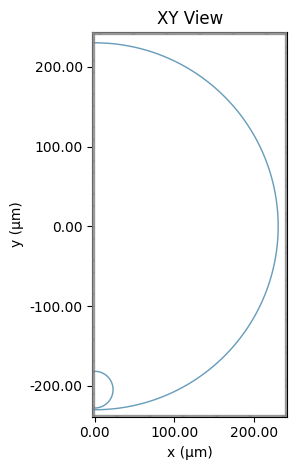

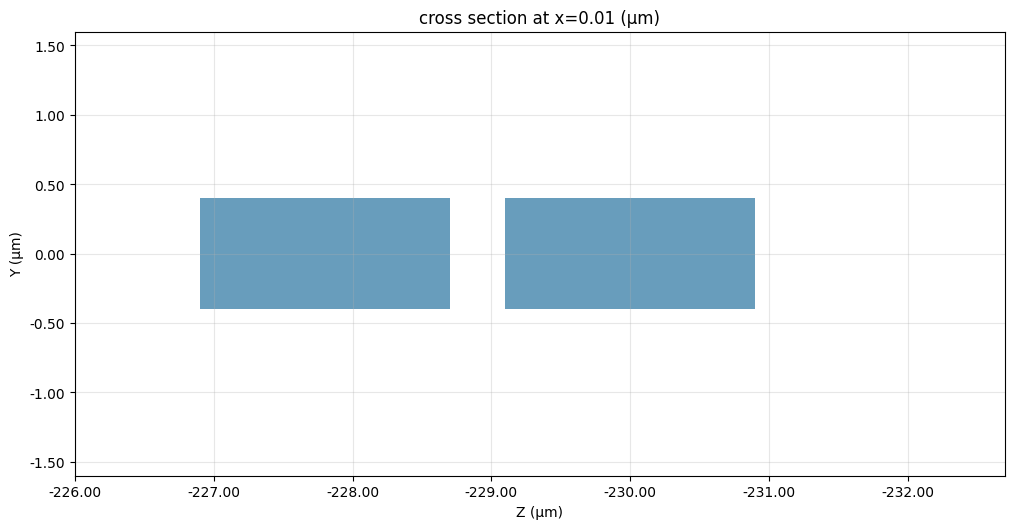

19:14:59 UTC WARNING: Use the remote mode solver with subpixel averaging for    
             better accuracy through 'tidy3d.web.run(...)' or the deprecated    
             'tidy3d.plugins.mode.web.run(...)'.                                

Mode overlap: 0.020528
kappa:  0.016437482595965978
coupling_length:  [8.56283447]
with an aux: [1.85979778] [1.76923584]


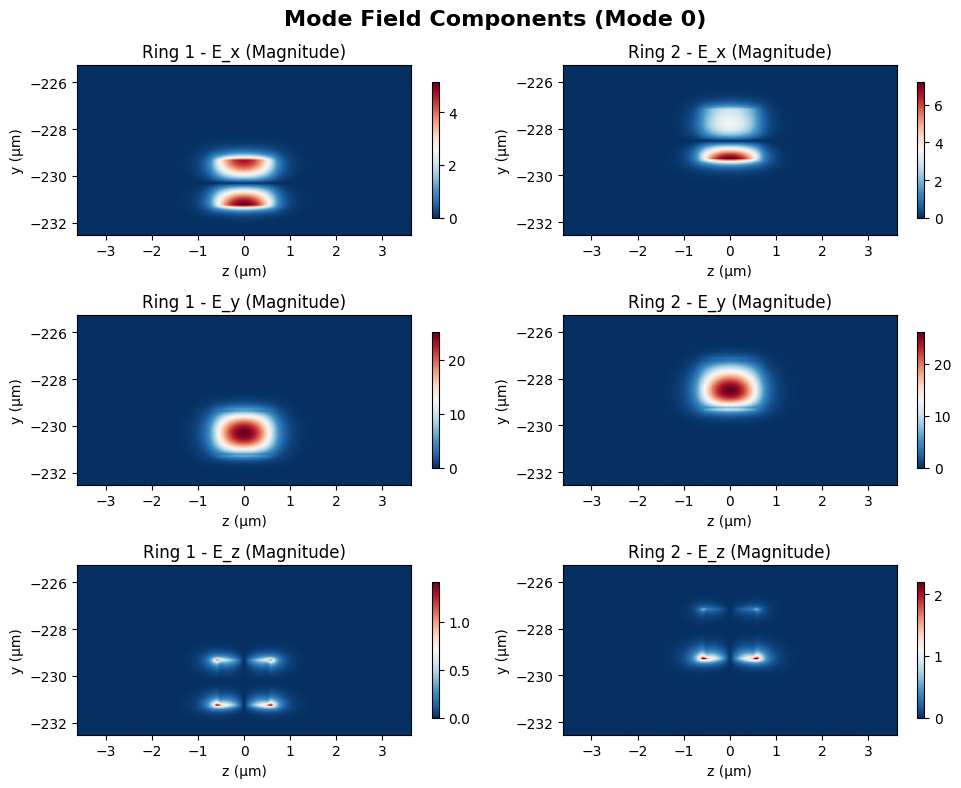

In [12]:
n_eff1, n_eff_plus2 = get_n_eff_2rings(matwg='Si3N4', matbg='SiO2',lambda0 = 1.55, wg_height = 0.8, wg_width = 1.8, radius1 = 230, radius2 = 23, gap = 0.4, lambdac = 1.4, ppw = 20, visualize_structure = True, plot_fields=True)

In [13]:
# Unit length is micron.
radius_big = 227.26
radius_aux = 23.36
width = 1.8
height = 0.74
gap = 0.45

# Constants
c = 3e8  # speed of light in vacuum (m/s)

# let's test the get_n_eff function
lambda_min = 1.5
lambda0 = 1.55       # pump wavelength
lambda_max = 1.6
nu_of_lambdas = 21

fmin = c/lambda_max
fmax = c/lambda_min
wavelengths = np.linspace(lambda_min, lambda_max, nu_of_lambdas)
# Initialize array to store results
n_eff_single_ring = []
n_eff_ring_next2ring_method1 = []
n_eff_ring_next2ring_method2 = []

for wavelength in wavelengths:
    n1, n2 = get_n_eff_2rings(matwg='Si3N4', matbg='SiO2',lambda0 = wavelength,
                                    wg_height = 0.74, wg_width = 1.8, radius1 = 227.26,
                                    radius2 = 23.36, gap = 0.45, lambdac = wavelengths[0], ppw = 20,
                                    visualize_structure = False, plot_fields=False)
    n_eff_single_ring.append(n1)
    n_eff_ring_next2ring_method2.append(n2)

# Convert to numpy array
n_eff_sr_values = np.array(n_eff_single_ring)
n_eff_r2r_m1 = np.array(n_eff_ring_next2ring_method1)
n_eff_r2r_m2 = np.array(n_eff_ring_next2ring_method2)

Mode overlap: 0.015154
kappa:  0.01180185335803118
coupling_length:  [8.23951823]
with an aux: [1.85794363] [1.76684936]
Mode overlap: 0.015402
kappa:  0.011995033727755188
coupling_length:  [8.2671275]
with an aux: [1.85705834] [1.76596649]
Mode overlap: 0.015653
kappa:  0.01219060091519139
coupling_length:  [8.29475366]
with an aux: [1.85617267] [1.76508354]
Mode overlap: 0.015907
kappa:  0.012388518590683325
coupling_length:  [8.32239595]
with an aux: [1.85528662] [1.7642005]
Mode overlap: 0.016164
kappa:  0.01258868961556835
coupling_length:  [8.35005627]
with an aux: [1.85440017] [1.76331738]
Mode overlap: 0.016424
kappa:  0.01279137473121023
coupling_length:  [8.37772795]
with an aux: [1.85351337] [1.76243416]
Mode overlap: 0.016688
kappa:  0.012996441930525505
coupling_length:  [8.4054215]
with an aux: [1.8526262] [1.76155094]
Mode overlap: 0.016954
kappa:  0.013203970322517088
coupling_length:  [8.43311864]
with an aux: [1.85173866] [1.76066754]
Mode overlap: 0.017224
kappa:  0

### Integrated Dispersion or the original ring resonator

D1 is  15.730982197352084  GHz


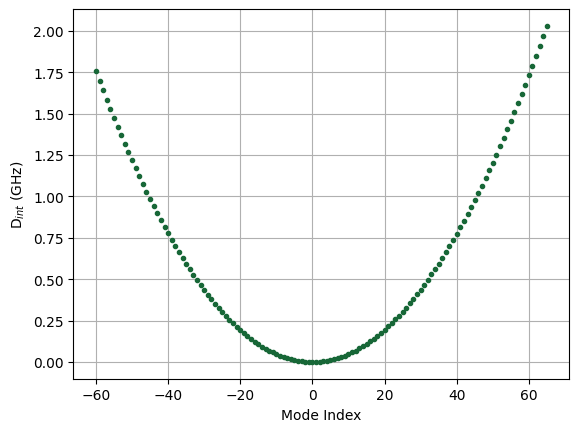

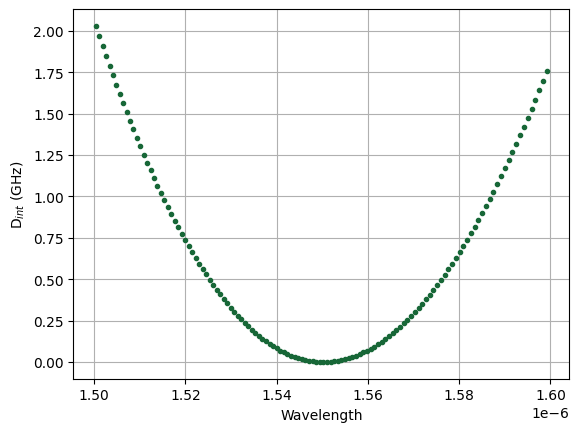

In [14]:
lambdas = wavelengths * 1e-6
n_eff = n_eff_sr_values.reshape(-1)


# lengths need to be converted to meters
w = width*1e-6
h = height*1e-6
R_central = radius_big*1e-6
target_lambda = lambda0*1e-6

N = len(lambdas) * 35   # if this function gives an error, increase this integer
M = 1   # there is only one design in this case

target_freq = c / target_lambda
f_pump = target_freq
fs = 3e8 / lambdas
k0s = 2 * np.pi / lambdas

my_array = abs(lambdas - 3e8 / target_freq)
iindex = np.argmin(my_array)

m_values1 = np.zeros((M, N))
lambdas1 = np.zeros((M, N))
Dint1_all = np.zeros((M, N))

omega = 2 * np.pi * c / lambdas
beta = n_eff * omega / c
mvalues1 = beta * R_central
mi_min = np.ceil(np.min(beta * R_central))
mi_max = np.floor(np.max(beta * R_central))
mi1 = np.arange(mi_min, mi_max + 1)

akima_interp = Akima1DInterpolator(np.flip(mvalues1), np.flip(n_eff))
n_effi1 = akima_interp(mi1)

freqs1 = c * mi1 / n_effi1 / (2 * np.pi * R_central)
lami1 = c / freqs1

# Find relative mode numbers
R = np.abs(freqs1 - f_pump)  # Find difference between pump frequency and each frequency
NN = np.argmin(R)  # Lowest difference is the index of pump frequency
m1 = mi1 - mi1[NN]

w0 = freqs1[NN]
w1 = (freqs1[NN + 1] - freqs1[NN - 1]) / 2
print('D1 is ', w1/np.pi/2/1e9, ' GHz')
Dint = freqs1 - w0 - w1 * m1

Dint1_all[0, :len(Dint)] = Dint
m_values1[0, :len(mi1)] = mi1
lambdas1[0, :len(lami1)] = lami1

l1 = lambdas1[m_values1>0]
m1 = m_values1[m_values1>0]- mi1[NN]
D1 = Dint1_all[m_values1>0]/1e9

plt.plot(m1, D1,'.')
plt.xlabel('Mode Index')
plt.ylabel('D$_{int}$ (GHz)')
plt.grid(True)
plt.show()

plt.plot(l1, D1,'.')
plt.xlabel('Wavelength')
plt.ylabel('D$_{int}$ (GHz)')
plt.grid(True)
plt.show()

### Integrated Dispersion with an Aux Ring

D1 is  15.73833903158347  GHz


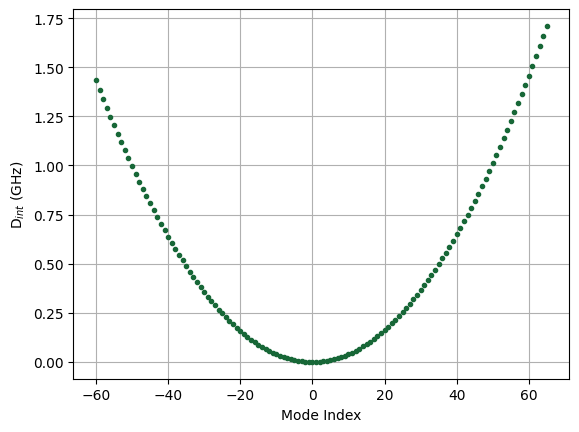

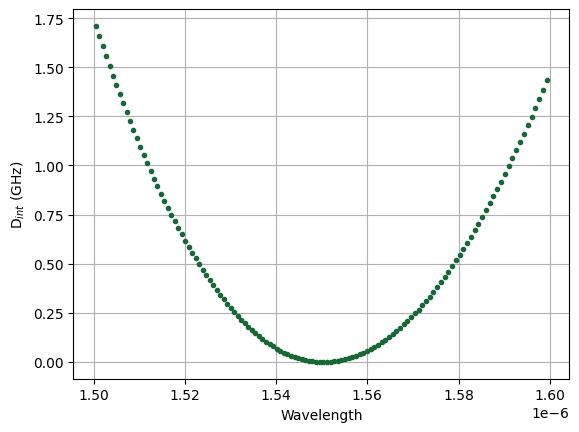

In [15]:
lambdas = wavelengths * 1e-6
n_eff = n_eff_r2r_m2.reshape(-1)

width = 1.8
height = 0.74
radius_big = 227.26
radius_aux = 23.36

# lengths need to be converted to meters
w = width*1e-6
h = height*1e-6
R_central = radius_big*1e-6

N = len(lambdas) * 35   # if this function gives an error, increase this integer
M = 1   # there is only one design in this case

target_freq = c / target_lambda
f_pump = target_freq
fs = 3e8 / lambdas
k0s = 2 * np.pi / lambdas

my_array = abs(lambdas - 3e8 / target_freq)
iindex = np.argmin(my_array)

m_values1 = np.zeros((M, N))
lambdas1 = np.zeros((M, N))
Dint1_all = np.zeros((M, N))

omega = 2 * np.pi * c / lambdas
beta = n_eff * omega / c
mvalues1 = beta * R_central
mi_min = np.ceil(np.min(beta * R_central))
mi_max = np.floor(np.max(beta * R_central))
mi1 = np.arange(mi_min, mi_max + 1)

akima_interp = Akima1DInterpolator(np.flip(mvalues1), np.flip(n_eff))
n_effi1 = akima_interp(mi1)

freqs1 = c * mi1 / n_effi1 / (2 * np.pi * R_central)
lami1 = c / freqs1

# Find relative mode numbers
R = np.abs(freqs1 - f_pump)  # Find difference between pump frequency and each frequency
NN = np.argmin(R)  # Lowest difference is the index of pump frequency
m1 = mi1 - mi1[NN]

w0 = freqs1[NN]
w1 = (freqs1[NN + 1] - freqs1[NN - 1]) / 2
print('D1 is ', w1/np.pi/2/1e9, ' GHz')
Dint = freqs1 - w0 - w1 * m1

Dint1_all[0, :len(Dint)] = Dint
m_values1[0, :len(mi1)] = mi1
lambdas1[0, :len(lami1)] = lami1

m2 = m_values1[m_values1>0]- mi1[NN]
l2 = lambdas1[m_values1>0]
D2 = Dint1_all[m_values1>0]/1e9

plt.plot(m2, D2,'.')
plt.xlabel('Mode Index')
plt.ylabel('D$_{int}$ (GHz)')
plt.grid(True)
plt.show()

plt.plot(l2,D2,'.')
plt.xlabel('Wavelength')
plt.ylabel('D$_{int}$ (GHz)')
plt.grid(True)
plt.show()

Let's plot the results together

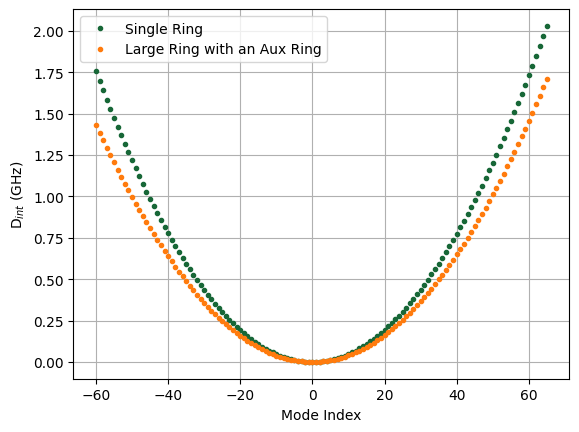

In [21]:
plt.plot(m1,D1,'.',label= 'Single Ring')
plt.plot(m2,D2,'.', label = 'Large Ring with an Aux Ring')
plt.legend()
plt.grid()
plt.xlabel('Mode Index')
plt.ylabel('D$_{int}$ (GHz)')
plt.show()